## **Introduction**


In Industry 4.0, predicting machine failures and identifying their causes is crucial, as repairing or replacing an entire machine is far costlier than fixing a single component. Installing sensors to monitor machine conditions enables industries to save significantly through predictive maintenance.

This study uses the AI4I Predictive Maintenance Dataset from the UCI Repository to demonstrate a typical machine learning workflow. After exploring and preprocessing the dataset, two main tasks are addressed:

(1) predicting whether a machine is likely to fail

(2) identifying the type of fault.



## 1) **Task and Data description** <a id="description"></a>

The dataset consists of 10 000 data points stored as rows with 14 features in columns:
* UID: Unique identifier (1–10,000).
* Product ID: Includes a quality label — L (low, 60%), M (medium, 30%), or H (high, 10%) — and a serial number.
* Air Temperature [K]: Random walk process normalized around 300 K with a standard deviation of 2 K.
* Process temperature [K]: generated using a random walk process normalized to a standard
deviation of 1 K, added to the air temperature plus 10 K;
* Rotational Speed [rpm]: Derived from a 2860 W power baseline with added normal noise.
* Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation
of 10 Nm and no negative values;
* Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used
tool in the process;
* Machine failure: label that indicates, whether the machine has failed in this particular data
point for any of the following failure modes are true.
The machine failure consists of five independent failure modes:
* tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear
time between 200 - 240 mins;
* heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference
between air- and process temperature is below 8.6 K and the tools rotational speed is below
1380 rpm;
* power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power
required for the process. If this power is below 3500 W or above 9000 W, the process fails;
* overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for
the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;
* random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process
parameters.
If at least one of the above failure modes is true, the process fails and the ’machine failure’
label is set to 1. It is therefore not transparent to the machine learning method, which of the
failure modes has caused the process to fail.

## 2) **Exploratory Analysis** <a id="EDA"></a>
Our data exploration starts by checking that each entry is unique and there are no duplicates;
this is done by veryfing that the number of unique ProductID corresponds to the number of
observations. Then we print a report to look for missing values and check the data type for each
column.

In [ ]:
import kagglehub
shivamb_machine_predictive_maintenance_classification_path = kagglehub.dataset_download('shivamb/machine-predictive-maintenance-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'machine-predictive-maintenance-classification' dataset.
Data source import complete.


In [ ]:
import os

print(shivamb_machine_predictive_maintenance_classification_path)


/kaggle/input/machine-predictive-maintenance-classification


In [ ]:
os.listdir(shivamb_machine_predictive_maintenance_classification_path)


['predictive_maintenance.csv']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import data
data_path = os.path.join(shivamb_machine_predictive_maintenance_classification_path, 'predictive_maintenance.csv')
data = pd.read_csv(data_path)
n = data.shape[0]
# First checks
print('Features non-null values and data type:')
data.info()
print('Check for duplicate values:',
      data['Product ID'].unique().shape[0]!=n)

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values: False



* There is no missing data;
* There are no duplicate values;
* Six columns are numerical features, including UDI;
* Three columns are categorical features, including ProductID.

To make this distinction more clear we set numeric columns to float type.

In [ ]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
# Rename features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

### 2.1) ID Columns <a id="ID"></a>
Before proceeding, we address the two ID columns, which could mislead the model since machine failures cannot depend on identifiers. The UDI column duplicates the dataframe index, while Product ID combines a type letter (L, M, H) with a serial number. Since the letter already represents the machine type and the numbers fall into type-based intervals, Product ID adds no new information and can be dropped. The histogram below shows the number distribution.

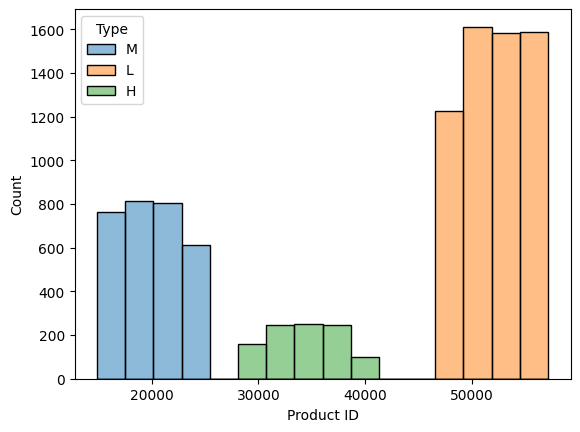

In [ ]:
# Remove first character and set to numeric dtype
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])

# Histogram of ProductID
sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()

In [ ]:
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

The following pie chart shows the percentages of machines by Type:

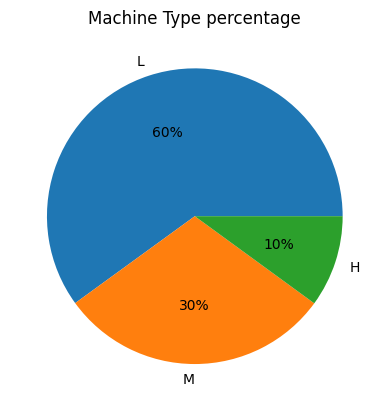

In [ ]:
# Pie chart of Type percentage
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

### 2.2) Target anomalies <a id="target"></a>

In this section we observe the distribution of the target to find any imbalances and correct them
before dividing the dataset.
The first anomaly respect to dataset’s description is that when the failure is random (RNF), the
Machine Failure feature is not set to 1.

In [ ]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']

# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index

# Show BEFORE: the original error
print('BEFORE - Original data with Target=0 for Random Failures:')
print(df.loc[idx_RNF, target])
print(f'\nNumber of Random Failure observations: {df.loc[idx_RNF, target].shape[0]}')

# Instead of dropping, set Target to 1 for Random Failures
df.loc[idx_RNF, 'Target'] = 1

# Show AFTER: verify the correction
print('\nAFTER - Corrected Target to 1 for Random Failures:')
print(df.loc[idx_RNF, target])

BEFORE - Original data with Target=0 for Random Failures:
      Target     Failure Type
1221       0  Random Failures
1302       0  Random Failures
1748       0  Random Failures
2072       0  Random Failures
2559       0  Random Failures
3065       0  Random Failures
3452       0  Random Failures
5471       0  Random Failures
5489       0  Random Failures
5495       0  Random Failures
5509       0  Random Failures
5553       0  Random Failures
5639       0  Random Failures
6091       0  Random Failures
6913       0  Random Failures
6960       0  Random Failures
7488       0  Random Failures
7868       0  Random Failures

Number of Random Failure observations: 18

AFTER - Corrected Target to 1 for Random Failures:
      Target     Failure Type
1221       1  Random Failures
1302       1  Random Failures
1748       1  Random Failures
2072       1  Random Failures
2559       1  Random Failures
3065       1  Random Failures
3452       1  Random Failures
5471       1  Random Failures
5489   

Going forward we find out that in 9 observations Machine failure is set to 1 when all types
of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove
these observations.

In [ ]:
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


### 2.3) Resampling with SMOTE <a id="resampling"></a>

Another important consideration regards the extremely low occurrence of machine failures among
the entire dataset, which percentage is equal only to 3.57%. Moreover, a pie plot showing the
occurrence of the causes involved for each failure reveals a further degree of imbalance.

Failures percentage in data: 3.48


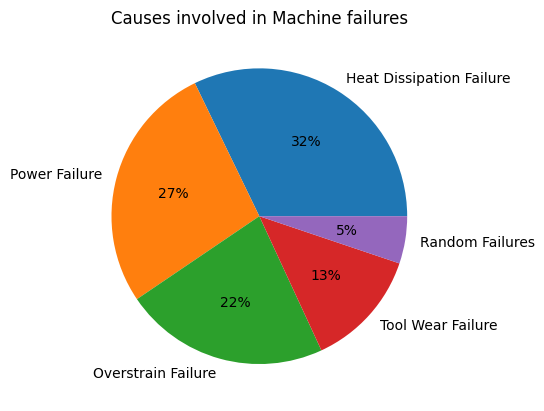

In [ ]:
# Portion of df where there is a failure and causes percentage
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:5], autopct='%.0f%%')
plt.show()

In machine learning, class imbalance can distort model training and result interpretation. For example, a model predicting “no machine failure” could still appear 97% accurate due to the imbalance. To address this, we apply data augmentation to achieve an 80:20 ratio between functioning and faulty machines and ensure balanced failure causes.

We use SMOTE (Synthetic Minority Oversampling Technique) to generate new, synthetic samples for the minority class , which is very much like slightly moving the data point in the direction of its neighbors. This way, the synthetic data point is not an exact copy of an existing data point but we can also be sure that it is also not too different from the known observations in the minority class.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc,
                 'Random Failures' :spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

### 2.4) Comparison after resampling <a id="resample_comparison"></a>

The result is described in the following pie charts.

Percentage increment of observations after oversampling: 26.69
SMOTE Resampled Failures percentage: 23.82


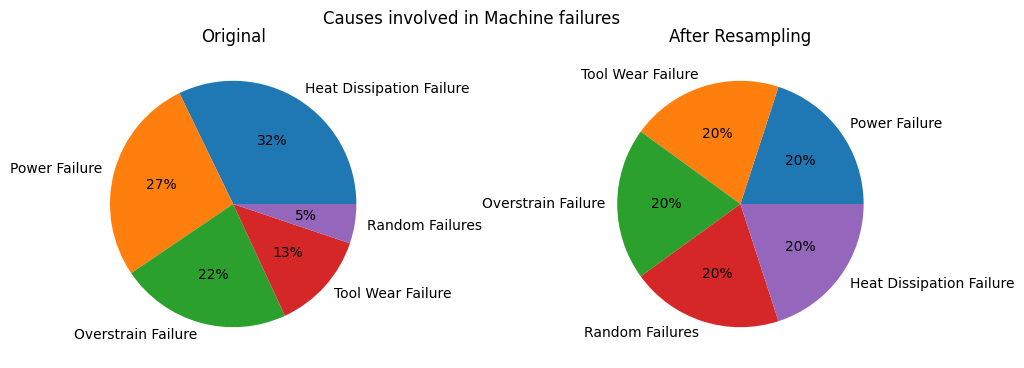

In [ ]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:5], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:5], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

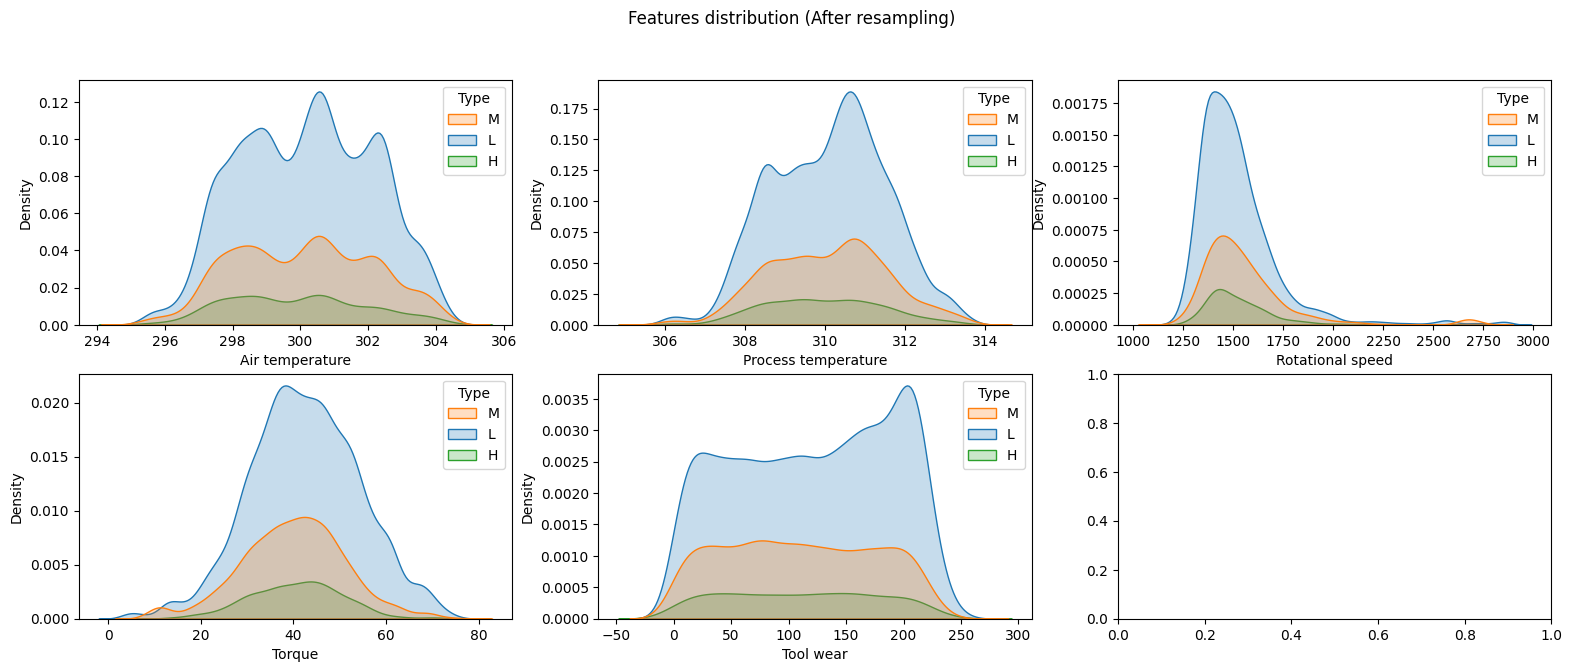

In [ ]:
# Kdeplot of numeric features (After resampling) - hue=Type
num_features = [feature for feature in features if df[feature].dtype=='float64']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

Finally, let’s look at how the distribution of features has changed.

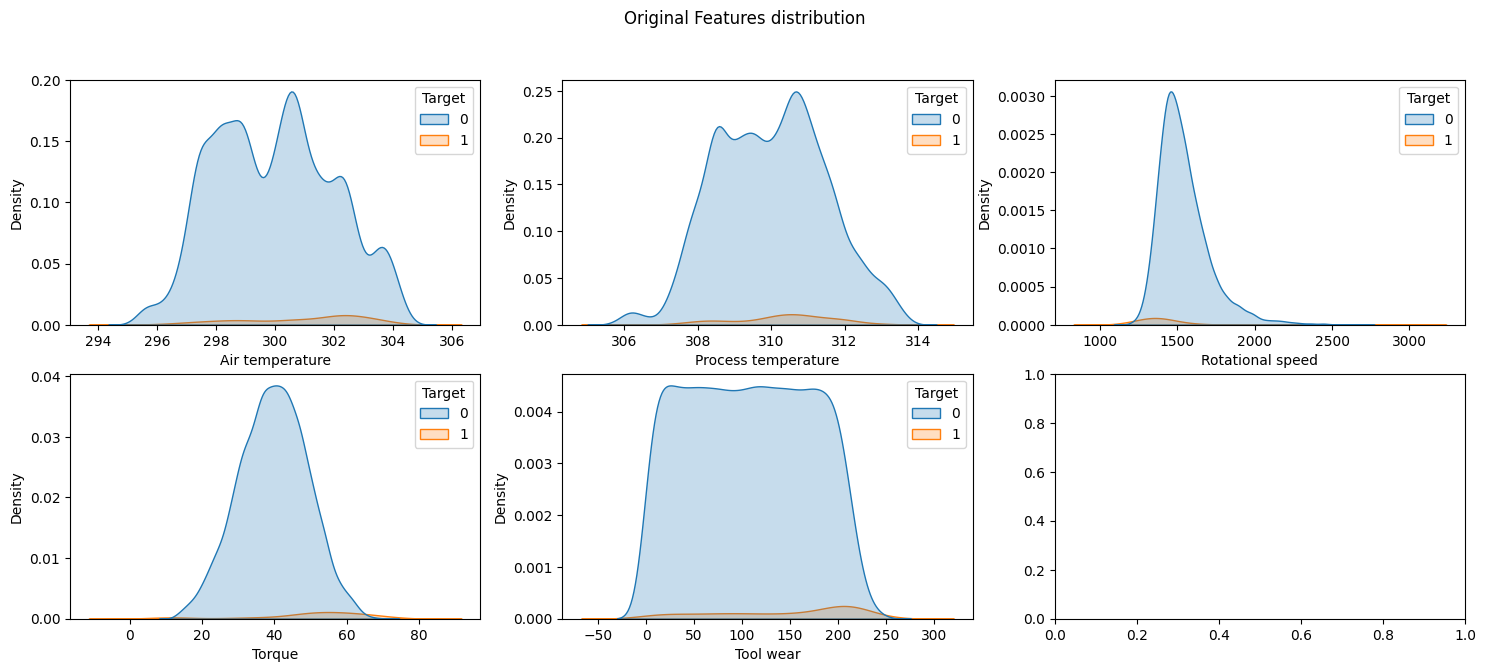

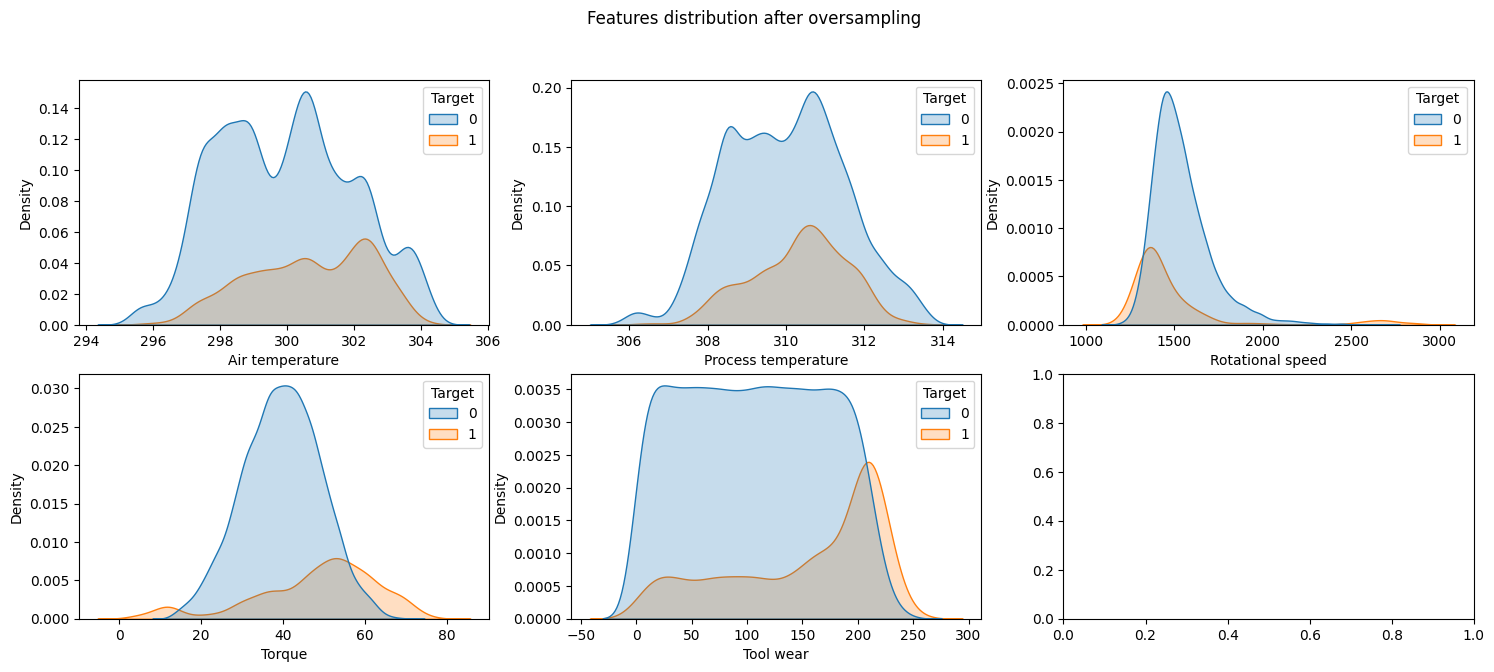

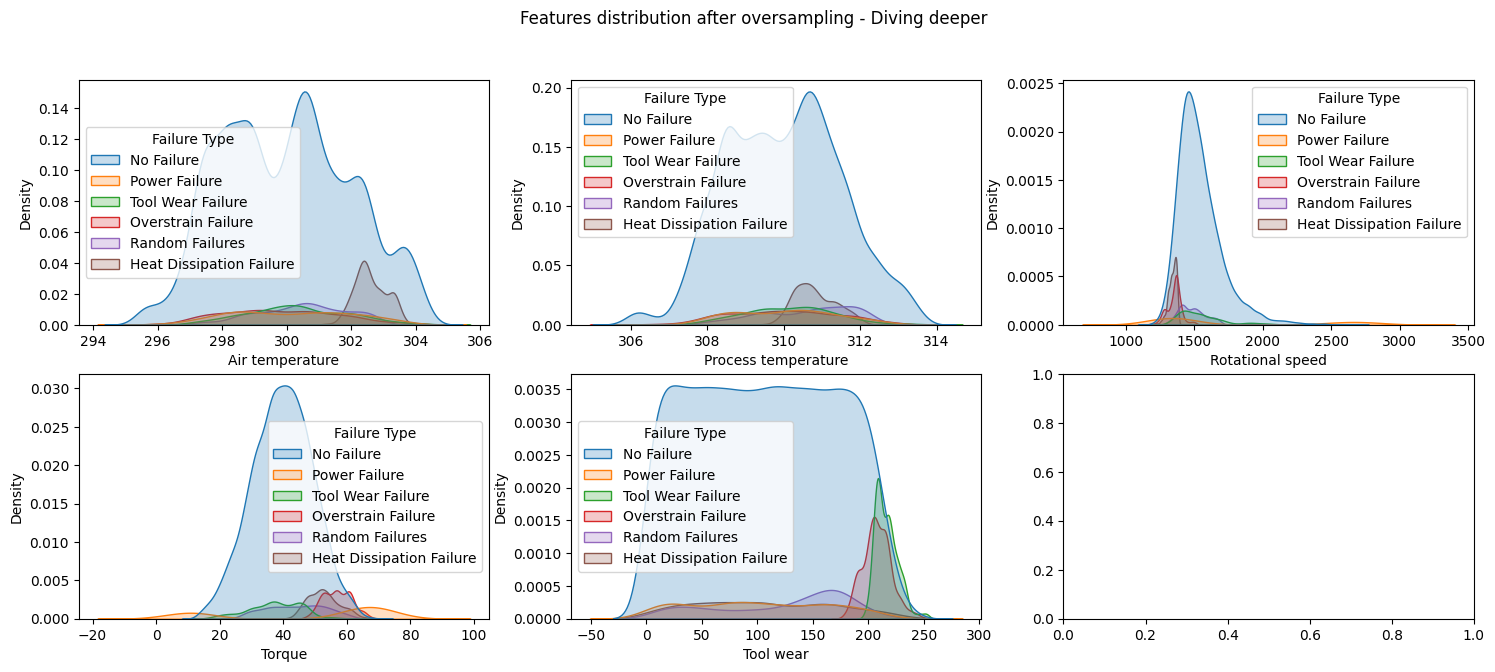

In [ ]:
# Kdeplot of numeric features (Original)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Original Features distribution')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature,
                hue='Target', fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Target'], fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling) - Diving deeper
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling - Diving deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Failure Type'], fill=True, palette='tab10')
plt.show()

### 2.5) Features scaling and Encoding <a id="encoding"></a>

In order to make data exploitable for the algorithms we will run, we apply two transformations:
* First, we apply a label encoding to the categorical columns, since Type is an ordinal feature
and Cause must be represented in one column. The mapping follows this scheme:
Type: {L=0, M=1, H=2}
Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
* Secondly we perform the scaling of the columns with StandardScaler. This is particularly
useful for the good working of methods that rely on the metric space, such as PCA.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4,
              'Random Failures': 5}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features])

/tmp/ipython-input-2855365716.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pre['Type'].replace(to_replace=type_dict, inplace=True)
/tmp/ipython-input-2855365716.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pre['Type'].replace(to_replace=type_dict, inplace=True)
/tmp/ipython-inp

### 2.6) PCA and Correlation Heatmap <a id="pca"></a>

We run PCA to have a further way of displaying the data instead of making feature selection.

In [ ]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    38.02
PC2    36.41
PC3    19.88
PC4     3.09
PC5     2.60
dtype: float64
Explained variance ratio with 3 components: 94.31


Since the first three components are enough to almost fully represent the variance of the data
we will project them in a three dimensional space.

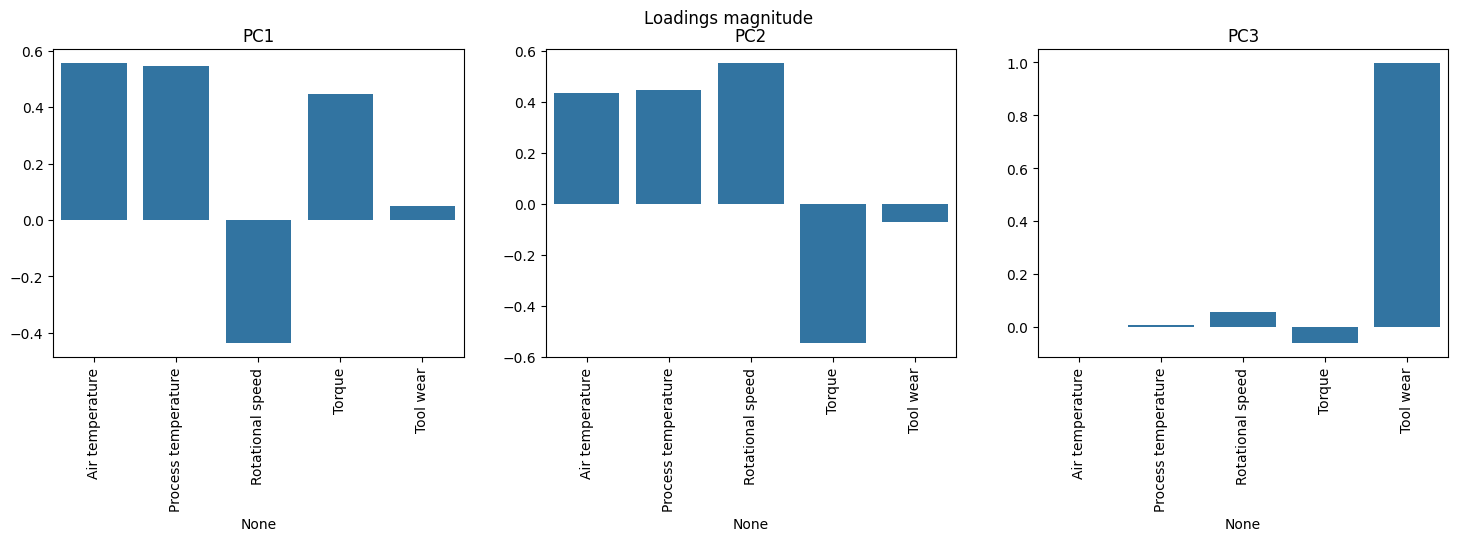

In [ ]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

The bar plot of Principal Components weights makes easy to understand what they represent:
* PC1 is closely related to the two temperature data;
* PC2 can be identified with the machine power, which is the product of Rotational Speed
and Torque;
* PC3 is identifiable with Tool Wear.

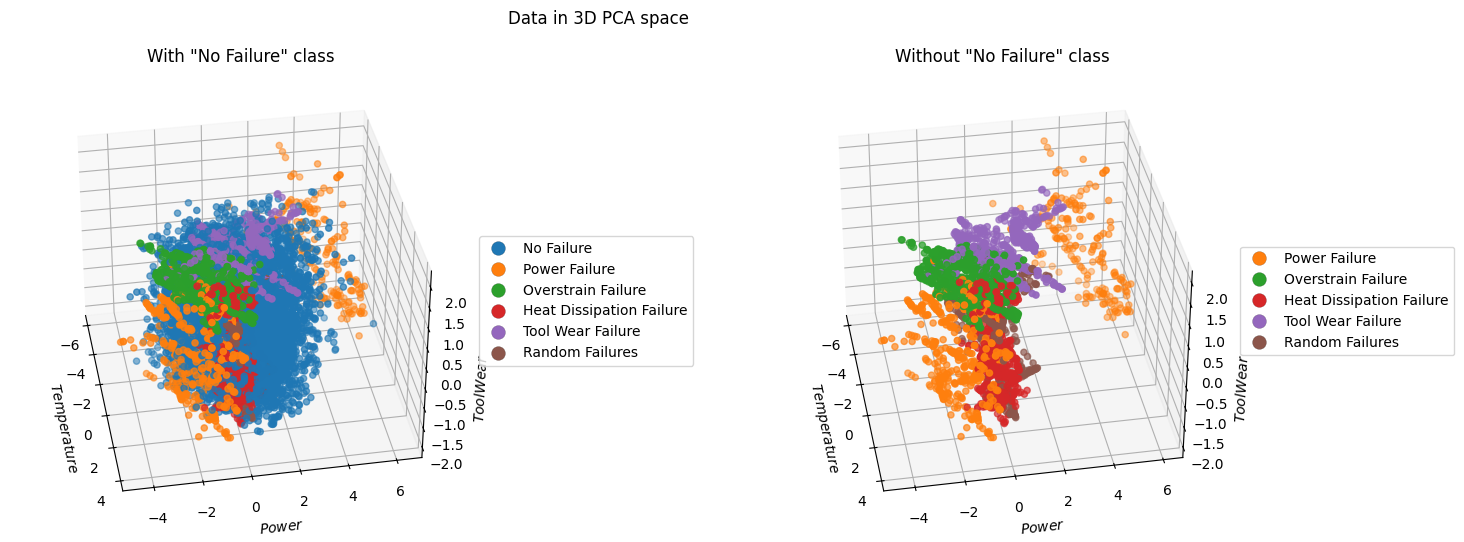

In [ ]:
X_pca3.rename(mapper={'PC1':'Temperature',
                      'PC2':'Power',
                      'PC3':'Tool Wear'}, axis=1, inplace=True)

# PCA plot
color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple',5:'tab:brown'})
color.append(col)
idx_w = col[col == 'tab:blue'].index
color.append(col.drop(idx_w))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
labelTups = [('No Failure','tab:blue'),
             ('Power Failure', 'tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure', 'tab:red'),
             ('Tool Wear Failure','tab:purple'),
             ('Random Failures','tab:brown')]

fig = plt.figure(figsize=(18,6))
fig.suptitle('Data in 3D PCA space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx,idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx,'Temperature'],
                    X_pca3.loc[idx,'Power'],
                    X_pca3.loc[idx,'Tool Wear'],
                    c=color[j])
    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With'+str(j*'out')+' "No Failure" class')
    ax.view_init(35, -10)
    custom_lines = [plt.Line2D([],[], ls="", marker='.',
                               mec='k', mfc=c, mew=.1, ms=20) for c in colors[j:]]
    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]],
              loc='center left', bbox_to_anchor=(1.0, .5))

plt.show()

The projection into the space generated by these three axes highlights that:
* TWF is the class of failures best separated from all the others and seems to depend almost
entirely on PC3 (Tool Wear);
* PWF occupies two extreme bands along the PC2 (Power), it is independent of the other
two components;
18
* The OSF and HDF classes are less separated than the others even if it can be observed
that the first is characterized by a high Tool Wear and low power while the second is
characterized by a high temperature and a low power.

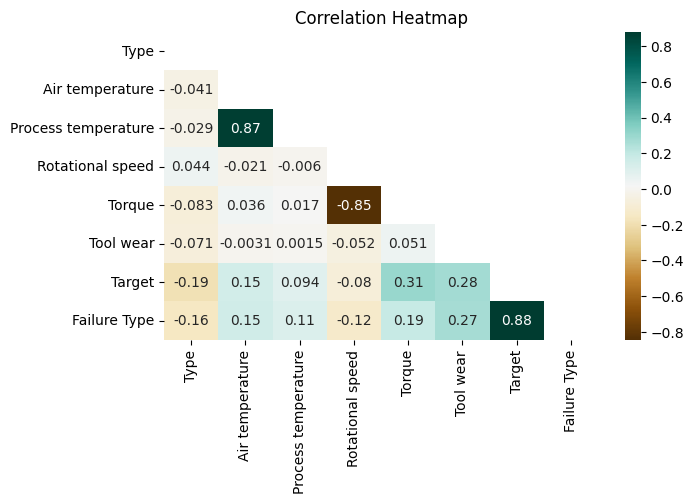

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

Unsurprisingly, we observe that the features related to temperature, as well as those related to
power, are widely correlated. Furthermore, Tool Wear correlates well with both of our targets,
confirming what we have observed by studying PCA. Finally, a less strong correlation is also
observed between the torsion and the two targets.

## 3) **Random Forest Training & Evaluation** <a id="Random Forest Training & Evaluation"></a>

Divide the data into train/validation/test sets and prepares the binary target labels for model training.

In [ ]:
# Keep your existing split as-is
X, y = df_pre[features], df_pre[['Target', 'Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0
)

# Binary targets (1 = failure, 0 = no failure)
y_train_bin = y_train['Target'].values
y_val_bin   = y_val['Target'].values
y_test_bin  = y_test['Target'].values


Create and train a Random Forest classifier on the training set.
The “balanced” mode automatically weights minority classes higher.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",   # helpful for imbalance
    n_jobs=-1,
    random_state=0
)
rf.fit(X_train, y_train_bin)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=0)

=== Random Forest Performance on Test Set ===
Accuracy: 0.9589 | F1: 0.9113 | F2: 0.8966 | AUC: 0.9903


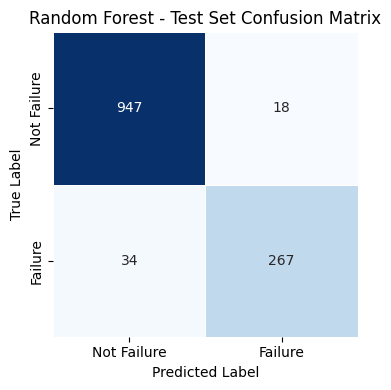


Classification Report:
              precision    recall  f1-score   support

 Not Failure     0.9653    0.9813    0.9733       965
     Failure     0.9368    0.8870    0.9113       301

    accuracy                         0.9589      1266
   macro avg     0.9511    0.9342    0.9423      1266
weighted avg     0.9586    0.9589    0.9585      1266



In [ ]:
# === Random Forest Evaluation (Single Confusion Matrix) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, fbeta_score,
    confusion_matrix, classification_report
)

# Evaluate model on Test Set
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test_bin, y_pred)
f1  = f1_score(y_test_bin, y_pred, zero_division=0)
f2  = fbeta_score(y_test_bin, y_pred, beta=2, zero_division=0)
auc = roc_auc_score(y_test_bin, y_proba)

print("=== Random Forest Performance on Test Set ===")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | F2: {f2:.4f} | AUC: {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred)
class_names = ["Not Failure", "Failure"]

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False,
    xticklabels=class_names, yticklabels=class_names,
    linewidths=.5, linecolor='white', square=True
)
plt.title("Random Forest - Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred, target_names=class_names, digits=4, zero_division=0))


In [ ]:
# Feature Importances
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop Feature Importances:")
print(fi.head(15))


Top Feature Importances:
Torque                 0.263287
Tool wear              0.251011
Rotational speed       0.221161
Air temperature        0.129065
Process temperature    0.093362
Type                   0.042113
dtype: float64
